# 🥱 LangGraph_基本反思 Agent篇

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 反思機制：AI的自我審視過程


在LLM代理構建中，反思指的是促使LLM觀察其過往步驟（包括來自工具或環境的觀察）並評估所選行動質量的過程。這一機制為AI帶來了諸多可能性：

動態調整行動計劃
優化搜索策略
提升整體性能

![圖片：反思過程示意圖]()

> 💡 關鍵點：反思機制使AI能夠像人類一樣，從經驗中學習並不斷改進。

# 環境建置

## 安裝套件包

在深入反思機制之前，我們需要先搭建實驗環境。以下是所需的套件安裝命令：

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 801.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.5/361.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81

我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 基本 Reflection-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

#小試身手：先嘗試 Reflection 概念

## 生成階段：AI創意的源泉

我們首先創建一個"五段式論文"產生器，作為我們的基礎AI模型：


In [ ]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "您是一位專業的論文助手，擅長撰寫出色的五段式論文。"
            " 請為用戶的要求生成最佳論文。"
            " 如果用戶提供批評，請根據之前的嘗試提供修訂版本。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(
    temperature=0.7,     # 調整溫度
    max_tokens=1024,      # 設定最大輸出 token 量,
    streaming=True
)
generate = prompt | llm

In [ ]:
essay = ""
request = HumanMessage(
    content="請寫一篇論文，探討《哈利波特》在現代童年中的相關性"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

論文題目：《哈利波特》在現代童年中的相關性

第一段：介紹《哈利波特》作為現代童年文學的重要性
《哈利波特》系列是J.K.羅琳所創作的一部著名奇幻小說，被廣泛認為是當代童書的經典之作。這個故事講述了一個普通男孩哈利波特在巫師世界中的冒險故事，融合了友情、勇氣、忠誠和愛等主題。《哈利波特》不僅在文學界取得了巨大成功，也在現代童年中扮演著重要的角色。

第二段：探討《哈利波特》對現代童年的影響
首先，《哈利波特》中的角色和情節能夠引起現代兒童的共鳴。哈利、妙麗和榮恩這些角色展現了友誼的重要性，鼓勵讀者珍惜友誼，並在困難時互相扶持。此外，故事中的魔法世界和挑戰激發了兒童的想像力，讓他們能夠逃避現實世界的壓力和困難。

第三段：分析《哈利波特》中探討的成長主題
《哈利波特》也深刻探討了成長和自我認識的主題，這對現代兒童來說至關重要。哈利從一個被忽略的男孩成長為一名英勇的巫師，這個轉變過程鼓勵讀者堅持追求夢想，並相信自己的能力。同時，小說中探討的家庭、友誼和勇氣等價值觀也為現代兒童提供了重要的啟示。

第四段：討論《哈利波特》對現代童年的教育意義
除了娛樂性，《哈利波特》還具有重要的教育意義。透過哈利波特的故事，兒童可以學習到如何應對挑戰、珍惜友誼、勇敢面對困難等價值觀。這些教訓將對他們未來的成長和發展產生積極的影響。

第五段：總結現代童年中《哈利波特》的重要性
總的來說，《哈利波特》作為一部當代童書，在現代童年中具有重要的相關性。這個故事不僅能夠啟發兒童的想像力和創造力，還能夠教導他們價值觀和人生道理。因此，我們應該重視《哈利波特》對現代兒童的影響，並在教育和文學中加以推廣。

這個產生器就像是一位全天候待命的寫作助手，隨時準備為您創作精彩論文。

### 反思模塊：AI的自我評價機制

接下來，我們實現AI的自我反思能力：

In [ ]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "您是一位正在評分論文的老師。請為用戶的作品提供批評和建議。"
            " 提供詳細的建議，包括長度、深度、風格等方面的要求。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

這篇論文初步探討了《哈利波特》在現代童年中的相關性，但還有一些地方可以進一步改進和加強。以下是一些建議：

1. **引言**：在引言部分，可以加入更多有關《哈利波特》系列在文學史上的地位及其對童書文學的影響的背景資料。這樣有助於引領讀者更深入地了解這個主題的重要性。

2. **分段組織**：在每個段落中，確保主題清晰，並使用過渡句子使得段落之間的關係更加流暢。比如在第二段之前可以加入一個過渡段落，介紹接下來要探討的主題，以提高文章的邏輯性和結構性。

3. **引用和分析**：為了加強論文的可信度和深度，建議在論述中引入一些相關的研究、評論或者學者觀點，並對這些觀點進行分析和評論。這樣可以讓讀者更容易理解你的立場，並且提供更多的證據支持你的論點。

4. **討論更多細節**：在討論《哈利波特》對現代童年的影響時，可以更進一步地探討一些具體的情節、角色或主題，例如哈利波特系列中的具體場景如何影響現代兒童的價值觀和行為，以及這些影響將如何塑造他們的成長道路等。

5. **結論**：在結論部分，可以總結前文所提到的主要論點，並提供一個總體性的觀點，強調《哈利波特》對現代童年的重要性以及對教育和文學領域的啟示。同時，也可以提出一些建議，例如如何更好地利用《哈利波特》這一作品來豐富現代兒童的閱讀經驗和教育成果。

總的來說，這篇論文已經具有一定深度和廣度，但通過以上建議的改進，可以使論文更加完整、具有說服力和洞察力。希望這些建議對您有所幫助，祝您的論文寫作順利！

這個反思過程讓AI能夠像一位嚴謹的評論家一樣審視自己的作品，為後續改進提供方向。

> 🔍 深入理解：反思模塊使AI能夠從多個角度評估自己的輸出，這是提升AI性能的關鍵步驟。

### 反覆修正：精進再精進

接下來就是重複到認為滿意為止，可以簡單地使用 for-loop 結構制定次數，或使用其他機制來判斷已經足夠。

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

修訂後的論文：

論文題目：《哈利波特》在現代童年中的相關性

引言
《哈利波特》系列作為J.K.羅琳的代表作，不僅在文學史上佔有一席之地，更在童書文學中留下了深遠的影響。這個故事以哈利波特在巫師世界的成長為主軸，融合了友誼、勇氣、自我認識等主題，深受兒童喜愛。本文旨在探討《哈利波特》在現代童年中的相關性，以及其對兒童成長和價值觀的影響。

第一段：《哈利波特》作為現代童年文學的重要性
《哈利波特》作為童書文學中的經典之作，不僅在文學界取得了巨大成功，也在現代童年中扮演著重要的角色。其故事情節引人入勝，角色形象栩栩如生，深受兒童和青少年的喜愛。

第二段：《哈利波特》對現代童年的影響
《哈利波特》中的角色和情節能夠引起現代兒童的共鳴。哈利、妙麗和榮恩這些角色展現了友誼的重要性，鼓勵讀者珍惜友誼，並在困難時互相扶持。故事中的魔法世界和挑戰激發了兒童的想像力，讓他們能夠逃避現實世界的壓力和困難。

第三段：《哈利波特》探討的成長主題
《哈利波特》深刻探討了成長和自我認識的主題，對現代兒童的教育意義重大。哈利從一個被忽略的男孩成長為一名英勇的巫師，這個轉變過程鼓勵讀者堅持追求夢想，並相信自己的能力。小說中探討的家庭、友誼和勇氣等價值觀也為現代兒童提供了重要的啟示。

第四段：《哈利波特》對現代童年的教育意義
《哈利波特》作為一部充滿教育意義的作品，通過故事中的情節和角色，向兒童傳遞了許多重要的價值觀和人生智慧。這些教訓將對他們未來的成長和發展產生積極的影響，幫助他們建立健康的價值取向和行為模式。

結論
總的來說，《哈利波特》作為一部當代童書，在現代童年中具有重要的相關性。這個故事不僅能夠啟發兒童的想像力和創造力，還能夠教導他們價值觀和人生道

## 使用 LangGraph 實現

剛剛已經將反思過程逐步拆解並且實現，接下來將其整合到整張 Graph 當中。

### 建立狀態

In [ ]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain.schema import BaseMessage, HumanMessage, AIMessage

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

### 定義工作節點

In [ ]:
async def generation_node(state: State) -> State:
    response = await generate.ainvoke(state["messages"])
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}

async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    messages = state["messages"]
    translated = [messages[0]] + [cls_map[msg.type](content=msg.content) for msg in messages[1:]]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return {"messages": state["messages"] + [HumanMessage(content=res.content)]}

def should_continue(state: State) -> str:
    if len(state["messages"]) > 6:
      # End after 3 iterations
        return END
    return "reflect"

> 🚀 提示：通過調整`should_continue`函數，你可以控制反思-生成循環的次數，從而平衡輸出品質和計算資源。

### 建構 Graph

In [ ]:
from langgraph.graph import END, StateGraph, START

builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")

builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

### 視覺化整張圖

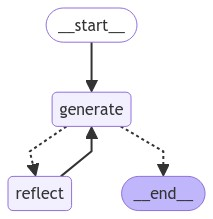

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

這個圖形結構不僅展示了AI的思維過程，還為我們提供了一個可調整和優化的框架。

In [ ]:
async for event in graph.astream({"messages": [HumanMessage(content="生成一篇論文，探討《小王子》及其信息在現代生活中的時代性")]}):
    print(event)
    print("---")

{'generate': {'messages': [HumanMessage(content='生成一篇論文，探討《小王子》及其信息在現代生活中的時代性', id='7ef15f3a-39e7-4bc2-a781-5ba942897e12'), AIMessage(content='標題：《小王子》在現代生活中的時代性探析\n\n引言：\n《小王子》是法國作家聖-埃克絮佩里的代表作品，被譽為世界文學經典之一。這部童話小說通過小王子的奇幻冒險，深刻探討了人性、友情、愛情和價值觀念等主題。然而，隨著時代的變遷，人們對《小王子》中的信息是否仍然具有時代性，值得深入探討。\n\n第一段：《小王子》中的人性與現代社會\n《小王子》中描述的人性特徵，如虛榮、自私、孤獨等，與現代社會中人們的行為和價值觀有著類似之處。隨著科技的發展和社會的變遷，人們的生活越來越忙碌，人與人之間的交流變得冷漠，這與小王子在星球上遇到的各種人相似。因此，小說中探討的人性問題在現代社會仍然具有重要性。\n\n第二段：友情和愛情的探討\n小王子和狐狸之間的友情以及小王子對玫瑰的愛情，讓人們思考真正的友情和愛情應該是什麼樣子。在現代社會，人們對友情和愛情的理解可能受到物質慾望和社交媒體的干擾，小說中的友情和愛情觀念提醒著人們回歸真摯、純潔的情感。\n\n第三段：價值觀念的反思\n小說中小王子對星球居民的價值觀念提出質疑，反映了對當時社會現象的批判。在現代社會中，價值觀觀念的多元化和變遷使得人們更需要思考自己的價值觀和生活態度。《小王子》中對價值觀念的反思，對現代社會仍然具有啟發意義。\n\n結論：\n總的來說，《小王子》所探討的人性、友情、愛情和價值觀念等主題，雖然是在特定時代背景下創作的，但其中蘊含的智慧和啟示在現代社會依然具有時代性。透過對《小王子》中信息的重新思考和詮釋，我們可以更好地理解自己和周遭世界，並尋找到適應當前社會的價值觀念和生活態度。', id='5febe71f-b92a-4070-a17e-61fa44079d44')]}}
---
{'reflect': {'messages': [HumanMessage(content='生成一篇論文，探討《小王子》及其信息在現代生活中的時代性', id='7ef15f3a-39e7-4bc2-a781-5ba942897e12'), AIMe

In [ ]:
import rich

rich.print(event['generate']['messages'][-1].content)

非常感謝您的建議！我將根據您提供的進一步建議對論文進行修改，以使其更加完善和具有學術性。

標題：《小王子》在現代生活中的時代性探析

引言：
《小王子》是法國作家聖-埃克絮佩里的代表作品，被譽為世界文學經典之一。這部童話小說通過小王子的奇幻冒險，深刻探討了人
性、友情、愛情和價值觀念等主題。然而，隨著時代的變遷，人們對《小王子》中的信息是否仍然具有時代性，值得深入探討。

第一段：《小王子》中的人性與現代社會
《小王子》中描述的人性特徵，如虛榮、自私、孤獨等，與現代社會中人們的行為和價值觀有著類似之處。進一步整合專家觀點和
學術資料，例如引用心理學家對人性特徵的分析，可以使論文更具學術性和可信度。

第二段：友情和愛情的探討
小王子和狐狸之間的友情以及小王子對玫瑰的愛情，反映了對真摯情感的渴望和追求。擴充具體情節和對話的分析，並將其與現代
社會中的相應例子進行對比，可以更生動地展示《小王子》的時代性。引用相關研究或文獻，進一步支持友情和愛情觀念的討論。

第三段：價值觀念的反思
小說中小王子對星球居民的價值觀念提出質疑，呼應了對當時社會現象的批判。在對比分析中融入更多專家觀點和學術資料，可以
進一步豐富論文的內容和分析。探討《小王子》中的價值觀念如何與當代社會價值觀的互動和對比，將有助於更深入地理解時代性
。

結論：
總的來說，《小王子》所探討的人性、友情、愛情和價值觀念等主題，具有跨越時代的普世性和啟發力。展望未來，進一步探討《
小王子》對當代社會的應用價值，提出具體的應用建議和未來研究的方向，可以為讀者提供更多思考和啟示。檢查語言表達的流暢
性和結構的連貫性，確保論文的閱讀和理解效果。

> 💡 建議：在實際應用中，可以考慮為不同類型的任務設計專門的反思提示，以獲得更精確的自我評估結果。

## 總結與展望
實現反思機制為AI賦予了類人的自我完善能力。儘管目前還處於初級階段，但它無疑是通向更智能、更自主的AI系統的重要一步。

## 關鍵要點回顧：

- 反思機制的循環性本質
- 多重嘗試對提升輸出質量的價值
- 結合外部反饋進一步增強反思效果的潛力